## Villin Headpiece HP35 with HDBSCAN. Adaptive Sampling.

Here we use the fast folding (Nle/Nle)-mutant of Villin Headpiece HP35, which has been previously discretized by using HDBSCAN, to run adaptive sampling with the following scoring functions: 'counts', 'populations', 'non_detailed_balance', and 'flux'.

The first thing one must do is download the data from [OSF](https://osf.io/gt49w/?view_only=4f16c7c723194a3c806999a6f37ab839) and then import a number of libraries we will need as we run this example, most unusual dependencies are listed in repo's README.

In [1]:
import h5py
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
from mastermsm.msm import msm
from mastermsm.msm import msm_lib
from mastermsm.trajectory import traj

### Load discretized trajectory

In [3]:
h5file = "./data/c-alpha-and-inverses/lag-tica-5/hdbscan_50_80.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['hdbscan'])
x = list(data)
f.close()

In [4]:
type(x), type(data), len(x), data.shape

(list, numpy.ndarray, 151932, (151932,))

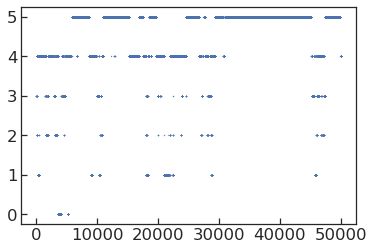

In [5]:
# show how trajectory goes over HDBSCAN clusters
plt.plot(data[:50000], '.', ms=0.5)

### MasterMSM: Obtain the reference MSM for later comparisons

In [6]:
distraj = traj.TimeSeries(distraj=x, dt=1)
distraj.find_keys()
distraj.keys.sort()

In [7]:
msm_villin=msm.SuperMSM([distraj], sym=False) #True

     # states: 6


In [8]:
msm_villin.convergence_test(time=[1, 2, 5, 10, 20, 50, 100, 200], error=True)
#msm_villin.convergence_test(time=[1, 2, 5, 10, 20, 50, 100, 200], error=False)

ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[  1636      0      0      0      3      0]
 [     0   5034     13      4      4      0]
 [     0     17   2302     20     24      0]
 [     1      2     24   6381     55      1]
 [     2      2     24     59  33306     53]
 [     0      0      0      1     53 102910]]


Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/imitxelena003/Programs/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/imitxelena003/Programs/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/imitxelena003/Programs/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/imitxelena003/Programs/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/imitxelena003/Progra

KeyboardInterrupt: 

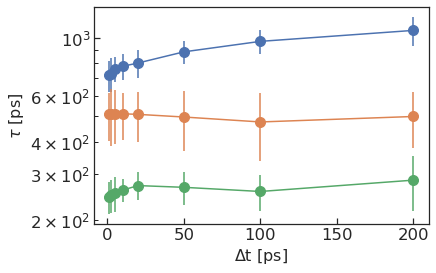

In [9]:
tau0_vs_lagt = np.array([[x,msm_villin.msms[x].tauT[0],msm_villin.msms[x].tau_std[0]] \
               for x in sorted(msm_villin.msms.keys())])
tau1_vs_lagt = np.array([[x,msm_villin.msms[x].tauT[1],msm_villin.msms[x].tau_std[1]] \
               for x in sorted(msm_villin.msms.keys())])
tau2_vs_lagt = np.array([[x,msm_villin.msms[x].tauT[2],msm_villin.msms[x].tau_std[2]] \
               for x in sorted(msm_villin.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau0_vs_lagt[:,0],tau0_vs_lagt[:,1],fmt='o-', yerr=tau0_vs_lagt[:,2], markersize=10)
ax.errorbar(tau1_vs_lagt[:,0],tau1_vs_lagt[:,1],fmt='o-', yerr=tau1_vs_lagt[:,2], markersize=10)
ax.errorbar(tau2_vs_lagt[:,0],tau2_vs_lagt[:,1],fmt='o-', yerr=tau2_vs_lagt[:,2], markersize=10)
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16), ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
_ = ax.set_yscale('log') #_ = ax.set_xscale('log')

In [8]:
# lag time selection after convergence test
lt = 100

In [9]:
#for lt in lagt:
msm_villin.do_msm(lt)
msm_villin.msms[lt].do_trans(evecs=True)

ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 1339     0     0     0   300     0]
 [    0  3627   261   492   675     0]
 [    0   362   385   355  1104   127]
 [   59   299   523  2721  2803    23]
 [  241   758  1090  2779 25120  3425]
 [    0     0    85   118  3372 99389]]


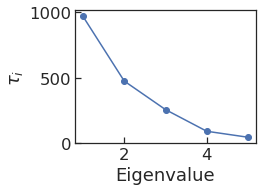

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
#ax.errorbar(range(1,len(msm_villin.msms[lt].tauT)+1), msm_villin.msms[lt].tauT , \
#        msm_villin.msms[lt].tau_std, fmt='-o')
ax.plot(range(1,len(msm_villin.msms[lt].tauT[:10])+1),msm_villin.msms[lt].tauT[:10],'-o')
ax.set_xlabel('Eigenvalue'), ax.set_ylabel(r'$\tau_i$')#, ax.set_yscale('log')
plt.tight_layout()

### Define routines for metrics

In [11]:
def msmpop(MSMp,MSMq,tr):
    mat = np.zeros((len(MSMp.trans[:,0]),len(MSMp.trans[:,0])))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keep_keys:
        for j in MSMq.keep_keys:
            iq,jq = MSMq.keep_keys.index(i), MSMq.keep_keys.index(j)
            ip,jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            mat[ip,jp] = mat[ip,jp] + MSMq.trans[iq,jq]
    
    auxmsm = msm.MSM(keys=MSMp.keys, lagt=MSMp.lagt, sym=MSMp.sym) #keys=MSMp.keep_keys
    auxmsm.trans, auxmsm.keep_states = mat, MSMp.keep_states
    tauT, peqT = auxmsm.calc_eigsT()
    
    score = 0.0
    for p,pq in zip(MSMp.peqT,peqT):
        score += ((pq - p)*(pq - p))#/p since p is used as weight
    
    return score #*100.

In [12]:
def relative_entropy_bowman(MSMp, matq, printmat=False):
    """ 
    Calculates relative entropy between reference (MSMp) and test (MSMq)
    using equilibrium probabilities as weights.
    Bowman et al. (JCTC, 2010; PNAS 2010)
    
    """
    mat = np.zeros((len(MSMp.trans[:,0]), len(MSMp.trans[:,0])))
    for i in MSMp.keep_keys:
        for j in MSMp.keep_keys:
            ip, jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            if MSMp.trans[ip,jp] and matq[ip,jp]:
                aux = np.log(MSMp.trans[ip,jp]/matq[ip,jp])
                mat[ip,jp] = MSMp.peqT[ip]*MSMp.trans[ip,jp]*aux
            else:
                mat[ip,jp] = 0 
    entropy = np.sum(mat[mat!=0])
    if printmat: 
        return entropy, mat
    return entropy

In [13]:
def relative_entropy(MSMp, matq, printmat=False):
    """ 
    Calculates relative entropy between reference (MSMp) and test (MSMq)
    Bowman, Ensign and Pande (JCTC, 2010)
    
    """
    mat = np.zeros((len(MSMp.trans[:,0]), len(MSMp.trans[:,0])))
    for i in MSMp.keep_keys:
        for j in MSMp.keep_keys:
            ip, jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            if MSMp.trans[ip,jp] and matq[ip,jp]:
                aux = np.log(MSMp.trans[ip,jp]/matq[ip,jp])
                mat[ip,jp] = MSMp.trans[ip,jp]*aux
            else:
                mat[ip,jp] = 0 
    entropy = np.sum(mat[mat!=0])
    if printmat: 
        return entropy, mat
    return entropy

In [14]:
def pseudo(MSMp, MSMq, tr):
    mat = np.zeros((len(MSMp.keys),len(MSMp.keys)))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
            keep_states=MSMp.keep_states, count=mat, normalize=False)
    return trans

In [15]:
def sortkeys(MSMp,MSMq,tr, evecs=True):
    mat = np.zeros((len(MSMp.keys),len(MSMp.keys)))
    #mat = MSMp.count
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
                keep_states=MSMp.keep_states, count=mat, normalize=False)
    if evecs is False: return trans
    
    #rvecsT, lvecsT = msm.calc_eigsT(evecs=True)
    auxmsm = msm.MSM(keys=MSMp.keys, lagt=MSMp.lagt, sym=MSMp.sym) #keys=MSMp.keep_keys
    auxmsm.trans, auxmsm.keep_states = trans, MSMp.keep_states
    tauT, peqT, rvecsT, lvecsT = \
                auxmsm.calc_eigsT(evecs=True)
    return trans, rvecsT

### Define routines for adaptive sampling

In [16]:
class adaptive_sampling(object):

    def __init__(self, reftraj=None, keys=None):
        
        self.reftraj, self.keys = reftraj, keys
        # initialize other classes
        self.resampler = resampler()
        self.msm = MSM()
        
           
    def guess(self, reftraj, keys, n_runs=10, random_inputs=True):
        
        self.reftraj, self.keys = reftraj, keys
        self.n_runs = n_runs
        
        tr = traj.TimeSeries(distraj=reftraj)
        tr.find_keys(), tr.keys.sort()
        state_kv, inputs = {}, []
        n_msm_runs = np.random.choice(range(len(keys)), n_runs)
        print('guess inputs:', n_msm_runs)
        for n in n_msm_runs:
            if n not in state_kv.keys():
                gen_dict_state([tr], keys, n, state_kv)
            try:
                frame, which_tr = random.choice(state_kv[n])
                inputs.append([frame, keys[n]])
            except IndexError:
                print('Error in gen_input, check n_msm_runs and MSM.keys')
    
        self.resampler.state_kv = state_kv
        self.resampler.inputs = inputs
        if not random_inputs:
            inputs = []
            [inputs.append([0,0]) for x in range(n_runs)]
            self.resampler.inputs = inputs
        
    
    def run(self, n_runs=10, n_epochs=10, nsteps=100, \
            lagt=10, scoring='counts', inputs=None, sym=False):
        
        if inputs is None and self.resampler.inputs is None:
            self.guess(self.reftraj, self.keys, n_runs=n_runs)
        elif inputs is not None:
            self.n_runs = len(inputs)
            self.resampler.inputs = inputs
            self.resampler.state_kv = {}
        
        self.msmepoch, self.inpepoch, self.trajfiles, n = [], [], {}, 0
        self.resampler.reftraj = self.reftraj
        
        self.chis = []
        while True:
            if n > n_epochs: break
            print('Epoch nº:',n)
            self.trajfiles[n] = self.resampler.resampler(self.reftraj, nsteps)
            self.msm.build_msm(self.trajfiles, lagt, sym)
            self.msmepoch.append(self.msm.msm)
            self.chis.append(self.chi2(self.msm.msm.count))
            self.resampler.scorer(self.msm.trs, self.msm.msm, self.n_runs, scoring, sym)
            self.inpepoch.append(self.resampler.inputs)
            n += 1
            
    def chi2(self, counts):
        norm, chi = 0.0, 0.0
        for i in range(len(counts)):
            norm += counts[i,i]*counts[i,i]
            for j in range(i):
                chi += (counts[i,j]-counts[j,i])*(counts[i,j]-counts[j,i])
                norm += counts[i,j]*counts[i,j]
                norm += counts[j,i]*counts[j,i]
        return chi

In [17]:
class resampler(object):
    
    def __init__(self, inputs=None, reftraj=None):
        
        self.inputs = inputs
        self.reftraj = reftraj
        self.state_kv = {}
    
    def resampler(self, reftraj, nsteps):
        
        trajfiles = []
        for inp in self.inputs:
            #print(nsteps,inp)
            data = reftraj[inp[0]:inp[0]+nsteps]
            trajfiles.append(data)

        return trajfiles
    
    
    def scorer(self, trs, mmsm, n_runs, scoring, sym):
    
        if scoring == "counts":
            states = counts(mmsm)
            #states = states.real
        elif scoring == "populations":
            states = populs(mmsm)
            #states = states.real
        elif scoring == "non_detailed_balance":
            if sym:
                raise Exception("Cannot impose symmetry with chosen scoring criteria.")
            states = non_detbal(mmsm)
        elif scoring == "flux":
            if sym:
                raise Exception("Cannot impose symmetry with chosen scoring criteria.")
            states = flux_inbalance(mmsm)
        else:
            sys.exit(" Please select one correct scoring.")

        self.inputs = self.gen_input(states, trs, mmsm.keys, mmsm.keep_states, n_runs, scoring)


    def gen_input(self, states, trs, keys, keep_states, n_runs, scoring):

        print('gen_input states:',states)
        if scoring == 'populations':
            n_msm_runs = np.random.choice(range(len(keep_states)), n_runs, p=states)
            aux = keep_states
        else:
            n_msm_runs = np.random.choice(range(len(keys)), n_runs, p=states)
            aux = keys

        tr = traj.TimeSeries(distraj=self.reftraj)
        tr.find_keys(), tr.keys.sort()
        #state_kv, inputs = {}, []
        inputs = []
        for n in n_msm_runs:
            if n not in self.state_kv.keys():
                #gen_dict_state(trs, aux, n, state_kv)
                gen_dict_state([tr], aux, n, self.state_kv)
            try:
                frame, which_tr = random.choice(self.state_kv[n])
                # 'n' stands for the index corresponding to a label
                inputs.append([frame, aux[n]])
            except IndexError:
                print('Error in gen_input, check n_msm_runs and MSM.keys')
    
        return inputs

In [18]:
def counts(mmsm):
    p = [(0.5/np.sum(mmsm.count[x, :]) + 0.5/np.sum(mmsm.count[:, x])) \
        if (np.sum(mmsm.count[x, x]) != 0) \
        else 0                        \
        for x in range(len(mmsm.keys))]
    if np.sum(p) == 0:
        sys.exit(" Error in 'resampler'. Please choose another 'scoring' option")
    return p/np.sum(p)

def populs(mmsm):
    #p = np.nan_to_num(1./mmsm.peqT, nan=0.0)
    p = [1./mmsm.peqT[i] if np.isreal(mmsm.peqT[i]) and \
         not np.isnan(mmsm.peqT[i]) else 0.0 for i in range(len(mmsm.keep_states))]
    return p/np.sum(p)

def non_detbal(mmsm):
    total = mmsm.count + np.transpose(mmsm.count)
    nondb = abs(mmsm.count - np.transpose(mmsm.count))/total
    nondb = np.sum(np.nan_to_num(nondb, nan=0.0), axis=1)
    states = [nondb[i] for i in range(len(mmsm.keys))]
    return states/np.sum(states)

def flux_inbalance(mmsm):
    flux = [(abs(np.sum(mmsm.count[x,:]) - np.sum(mmsm.count[:,x]))/\
    (np.sum(mmsm.count[:,x]) + np.sum(mmsm.count[x,:]))) \
    if (np.sum(mmsm.count[:,x]) + np.sum(mmsm.count[x,:])) >= 1
    else 0 \
    for x in range(len(mmsm.keys))]
    #this is done by above abs: flux += np.min(flux)
    if np.sum(flux) == 0:
        sys.exit(" Error in 'resampler'. Please choose another 'scoring' option")
    return flux/np.sum(flux)

In [19]:
def gen_dict_state(trs, keys, s, state_kv):
    state_kv[s] = []
    n = 0
    for t in trs:
        n +=1
        try:
            ivals = list_duplicates_of(t.distraj, keys[s])
            for i in ivals:
                state_kv[s].append([i, n-1])
        except KeyError:
            pass

In [20]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [21]:
class MSM(object):
    
    def __init__(self, trs=None, msm=None):
        
        self.trs, self.msm = trs, msm
    

    def build_msm(self, trajfiles, lagt, sym):
    
        trs = []
        for epoch in trajfiles.values():
            for data in epoch:
                tr = traj.TimeSeries(distraj=data) #, dt=dt
                tr.find_keys(), tr.keys.sort()
                trs.append(tr)
    
        # Invoke SuperMSM to collect keys from all trajectories
        smsm = msm.SuperMSM(trs, sym=sym)
        mymsm = msm.MSM(data=trs, keys=smsm.keys, lagt=lagt, sym=sym)
        mymsm.do_count()
        mymsm.do_trans(evecs=True)
        
        self.trs, self.msm = trs, mymsm

## Adaptive sampling vs. Plain MD

Any adaptive sampling algorithm should improve molecular dynamics calculations with the same amount of cumulative simulation data, so below we compare both of them. Plots similar to the ones used by Hruska et al. JCTC 2020 are employed.

In [148]:
n_epochs, n_runs = 10, 40
lt

100

In [149]:
aux = {}
mychis = []
for nts in np.arange(200,500,200):
    aux[nts] = []
    for i in range(10):
        test = adaptive_sampling()
        test.guess(x, msm_villin.msms[lt].keys, \
                   n_runs=n_runs, random_inputs=True)
        test.run(nsteps=nts, lagt=lt, scoring='non_detailed_balance',\
                n_epochs=n_epochs, sym=False, n_runs=n_runs)
        aux[nts].append(test.msmepoch)


guess inputs: [0 3 3 4 5 5 0 5 4 1 1 5 4 2 1 1 5 3 4 4 0 3 0 2 5 5 3 2 4 2 3 5 1 3 5 1 1
 0 2 2]
Epoch nº: 0
     # states: 6
ionix keep_states: [0, 1, 2, 4, 5]
ionix count matrix: [[229   0   6   0   0   0]
 [ 87 260 138   0  17  83]
 [140 100 992  94 133 126]
 [  0   0   0 800   0   0]
 [  0  65   0   0 521   7]
 [  0  24  25   0  34  19]]
gen_input states: [0.14658443 0.17552387 0.28634564 0.07643331 0.17150889 0.14360387]
Epoch nº: 1
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 717    0    6    0    0    0]
 [ 110  288  263    0   17  198]
 [ 231  340 2244   94  133  400]
 [   0   10   71 1353    0    0]
 [   0   65    0    0  921   59]
 [   0   58   87    0   82  153]]
gen_input states: [0.15836853 0.26484044 0.23228154 0.0925655  0.14204879 0.10989519]
Epoch nº: 2
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 888    0   50    0    0    0]
 [ 110  627  267    0  167  246]
 [ 616  496 2816   94  327  510]
 [   0   10 

gen_input states: [0.12054627 0.21485072 0.22530561 0.11387265 0.19052286 0.13490188]
guess inputs: [5 3 3 3 2 2 4 3 4 0 5 3 2 1 5 1 2 3 1 3 3 4 1 3 2 1 3 5 1 4 1 1 4 3 2 2 4
 5 3 3]
Epoch nº: 0
     # states: 6
ionix keep_states: [1, 2, 3, 4]
ionix count matrix: [[ 688    9   76    0    0    0]
 [   0  317   88   29   15    0]
 [   0  298 1102  256  130    0]
 [   0   71   44   72   80    0]
 [   0   15    0   30  480    0]
 [   0    0    0    0    0  100]]
gen_input states: [0.1951123  0.19160432 0.31712656 0.15425696 0.14189985 0.        ]
Epoch nº: 1
     # states: 6
ionix keep_states: [1, 2, 3, 4]
ionix count matrix: [[ 809   17  135   12    0    0]
 [   0  485  365  219  173   26]
 [   0  490 2316  353  152   41]
 [   0   71  165  388  255    0]
 [   0   30   37   49  812    0]
 [   0    0    0    0    0  500]]
gen_input states: [0.18726571 0.2097986  0.19460646 0.15923271 0.12425272 0.12484381]
Epoch nº: 2
     # states: 6
ionix keep_states: [1, 2, 3, 4]
ionix count matrix: [[13

gen_input states: [0.21159926 0.1962044  0.16926152 0.13490509 0.21967856 0.06835116]
guess inputs: [0 0 5 5 5 1 2 3 0 3 0 3 2 2 3 4 5 3 5 2 4 0 5 3 3 1 5 3 4 3 5 2 5 0 1 0 3
 0 2 5]
Epoch nº: 0
     # states: 6
ionix keep_states: [1, 4, 5]
ionix count matrix: [[521   0   0   0   0   0]
 [  0 955   0   0  21   0]
 [  0   0 314   0   0  86]
 [  0   0   0 107   0   0]
 [196  45   0 214 643 444]
 [ 36   0   0  64  67 287]]
gen_input states: [0.16389666 0.02979939 0.08194833 0.16389666 0.254155   0.30630394]
Epoch nº: 1
     # states: 6
ionix keep_states: [1, 2, 3, 4, 5]
ionix count matrix: [[ 936    0    0    0    0    0]
 [   0 1567    0    0   78    0]
 [   0    0  496   18   34   86]
 [   0    0   12  152   21  110]
 [ 282  133   75  391 2097  645]
 [ 126    0   15   89  133  487]]
gen_input states: [0.19225356 0.02505674 0.12295741 0.11569684 0.30692956 0.23710589]
Epoch nº: 2
     # states: 6
ionix keep_states: [1, 2, 3, 4, 5]
ionix count matrix: [[1760    0    0    0    0    0]
 [  

gen_input states: [0.12456252 0.05584865 0.15929188 0.2205834  0.1713272  0.26838635]
guess inputs: [5 1 4 4 4 3 3 4 1 2 4 5 0 4 5 0 5 1 3 1 2 1 4 5 5 1 2 4 4 2 5 5 2 0 0 4 1
 4 5 0]
Epoch nº: 0
     # states: 6
ionix keep_states: [0, 2, 3, 4]
ionix count matrix: [[778   0 213 114 113  40]
 [135 946   0  27   8   0]
 [ 79   0 369  39  15   0]
 [170   0 167   6   0   0]
 [123   0  87  23 148   0]
 [  0   0   0   0   0 400]]
gen_input states: [0.19204203 0.21350181 0.12711511 0.20058796 0.19558582 0.07116727]
Epoch nº: 1
     # states: 6
ionix keep_states: [0, 2, 3, 4]
ionix count matrix: [[1491    0  530  186  312  125]
 [ 200 1126    0   27   28    0]
 [  79    0 1209   96   68    0]
 [ 300    0  271   25  142    0]
 [ 394    0  233  114  316   59]
 [   0    0    0    0    0  669]]
gen_input states: [0.21390941 0.20759348 0.12217363 0.12599417 0.19193367 0.13839565]
Epoch nº: 2
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4]
ionix count matrix: [[2418   90  766  436  316  220]
 [ 2

gen_input states: [0.14523074 0.22546437 0.15034329 0.20576793 0.18458921 0.08860446]
guess inputs: [0 4 1 5 1 3 2 2 3 5 2 5 5 2 2 3 3 4 0 4 5 1 3 2 0 3 3 5 2 4 4 3 1 0 3 4 0
 5 4 3]
Epoch nº: 0
     # states: 6
ionix keep_states: [1, 2, 3, 4, 5]
ionix count matrix: [[433   0   0   0   0   0]
 [  8 937 139 112 115 337]
 [  0 130 514   0   0   0]
 [  0  89   0 180  23 160]
 [  0  90   7  34 135  78]
 [ 59  63  23  55  76 196]]
gen_input states: [0.17701691 0.17301954 0.17997816 0.07043347 0.11753221 0.28201972]
Epoch nº: 1
     # states: 6
ionix keep_states: [1, 2, 3, 4, 5]
ionix count matrix: [[ 802    0    0    0    0    0]
 [ 122 1523  139  188  185  593]
 [   0  303 1363    0    0    0]
 [   0  121    0  898   86  184]
 [   0  122   40  112  218   78]
 [ 163  121   23   55  129  425]]
gen_input states: [0.15694684 0.19258518 0.18606367 0.06967581 0.12421571 0.2705128 ]
Epoch nº: 2
     # states: 6
ionix keep_states: [1, 2, 3, 4, 5]
ionix count matrix: [[1273    0    0    0    0    0

gen_input states: [0.18689465 0.23491139 0.09884109 0.1506828  0.190223   0.13844706]
guess inputs: [4 2 3 4 1 5 3 0 4 1 4 1 3 1 3 4 5 4 0 4 4 0 3 0 0 5 2 5 1 4 0 0 4 2 3 5 2
 4 4 4]
Epoch nº: 0
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[1707  100    0    0    0    0]
 [ 101 4113  218  835  246  217]
 [   0  149   24   75  121    0]
 [ 173  622  145 1575   67    0]
 [   0  107   39   81  155    0]
 [   0  131    0    0    0  999]]
gen_input states: [0.17295266 0.16866674 0.17531341 0.26829274 0.17224486 0.04252958]
Epoch nº: 1
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[2816  100    0    0    0    0]
 [ 272 7650  518 1975  536  222]
 [   0  385   52  103  165    0]
 [ 291 1128  271 2836   67    0]
 [   0  330  127  268 1940    0]
 [   0  407   38    8    0 1495]]
gen_input states: [0.13070976 0.12644098 0.1543296  0.29694262 0.08652327 0.20505376]
Epoch nº: 2
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix 

ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 9980   596  1490   852     0     0]
 [  969  1135  1050  1637     0    68]
 [  796  2133  9876  5225   459     0]
 [ 1916  4536  8350 25609  2029   803]
 [    0     0     0   366 10911     0]
 [    0    44   223  4109     0 24029]]
gen_input states: [0.08348092 0.11377753 0.25901133 0.22094376 0.15269798 0.17008848]
Epoch nº: 10
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[10583   606  1490  1028     0     0]
 [  970  1256  1084  1708     0    68]
 [  802  2349 10632  5534   459     0]
 [ 2049  5130  8798 29080  2150   903]
 [    0     0     0   482 13131     0]
 [    0    77   231  4569     0 26022]]
gen_input states: [0.08102288 0.10909587 0.27194281 0.22192699 0.15339166 0.16261978]
guess inputs: [5 1 3 2 2 2 2 4 5 5 3 1 4 4 3 4 1 3 5 1 3 0 3 2 2 1 0 0 2 0 0 0 2 4 5 2 1
 0 2 0]
Epoch nº: 0
     # states: 6
ionix keep_states: [1, 2, 3, 4]
ionix count matrix: [[2047    0   86  246   14    0]
 

gen_input states: [0.16917776 0.20741897 0.20084555 0.11104347 0.09747377 0.21404047]
Epoch nº: 8
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 1086  1445     0     0  1542   530]
 [ 3474 20502   371  2195  2603  5825]
 [  204  2902 22033     0     0   438]
 [    0   751     0 12291     0     0]
 [  641   237     0     0 11840   882]
 [ 2085  3026     0  1108  1114  7677]]
gen_input states: [0.17411888 0.20328945 0.19954983 0.10722272 0.0980061  0.21781302]
Epoch nº: 9
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 1207  1495     0     0  1571   564]
 [ 3652 22098   534  2511  2755  6812]
 [  218  2960 26997     0     0   524]
 [    0   751     0 13658     0     0]
 [  641   292     0     0 12219   927]
 [ 2283  3657     0  1243  1114  8119]]
gen_input states: [0.17760435 0.20081825 0.19585152 0.11190987 0.0959795  0.21783651]
Epoch nº: 10
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 1366  1

ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[  971   489  1051     0  1269     0]
 [ 1494  4957  2812     0   807   400]
 [ 2970  5642 18964   695  2054   897]
 [   89   225  2735 14622     0     0]
 [  420  1054   380     0 10972     0]
 [    0     0    90     0     0  7483]]
gen_input states: [0.17625458 0.21081266 0.2064076  0.18391197 0.09378248 0.12883071]
Epoch nº: 7
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 1105   506  1198     0  1371     0]
 [ 1670  5425  3077     0   807   495]
 [ 3263  6307 22386   695  2155  1321]
 [   89   225  3371 16458     0     0]
 [  597  1241   502     0 12348     0]
 [    0     0    90     0     0  8840]]
gen_input states: [0.16839018 0.217681   0.2084388  0.18719462 0.08643293 0.13186247]
Epoch nº: 8
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 1156   506  1303     0  1408     0]
 [ 1867  6198  3796     0   914   541]
 [ 3588  7160 24434   734  2255  1421]
 [  113  

gen_input states: [0.20928313 0.20695595 0.14870029 0.21612868 0.09013884 0.12879313]
Epoch nº: 5
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[10526  2321   121   167     0     0]
 [  292 17515  2303  4371  1358  1524]
 [    0   719   656   867   446     0]
 [    0  2258  1127  4270   673   484]
 [    0   487   210   314  7755     0]
 [    0   201     0     0     0 10120]]
gen_input states: [0.20682109 0.21292556 0.15004507 0.20953017 0.08905787 0.13162024]
Epoch nº: 6
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[12431  2678   149   339     0     0]
 [  350 20445  2633  5024  1563  1824]
 [    0   880   718   867   491     0]
 [    0  2494  1284  5323   699   484]
 [    0   487   213   415  9885     0]
 [    0   468     0     0     0 10941]]
gen_input states: [0.21089243 0.20723875 0.15901745 0.21214933 0.08947324 0.1212288 ]
Epoch nº: 7
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[14906  29

ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 5394     0    70   378  1870     0]
 [    0  4389   173   514   427     0]
 [    0   273   556   459   813     0]
 [    0   419   700  3529  1655   118]
 [  203   791  1083  3313 13453   784]
 [    0     0     0     0   106  6061]]
gen_input states: [0.23865447 0.05318274 0.13400693 0.2249817  0.1992317  0.14994245]
Epoch nº: 4
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 6922     0    70   378  2300     0]
 [    0  5041   173   540   513     0]
 [    0   282   625   459   886     0]
 [    0   419   789  3985  1923   334]
 [  239   966  1237  4237 17945  1139]
 [    0     0     0     0   106  8023]]
gen_input states: [0.22975905 0.05491376 0.13640691 0.22604175 0.20336438 0.14951415]
Epoch nº: 5
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 8910     0    70   378  2469     0]
 [    0  5621   174   746   606     0]
 [    0   362   713   681  1030     0]
 [    0  

In [151]:
def pseudo(MSMp, MSMq, tr):
        
    mat = np.zeros((len(MSMp.keep_keys),len(MSMp.keep_keys)))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
            keep_states=MSMp.keep_states, count=mat, normalize=False)
    return trans

In [153]:
matent, mattim = np.zeros((n_epochs,len(np.arange(200,500,200))), float), np.zeros((n_epochs,len(np.arange(200,500,200))), float)
matmpop, matpop = np.zeros((n_epochs,len(np.arange(200,500,200))), float), np.zeros((n_epochs,len(np.arange(200,500,200))), float)
ent = []
pop, mpop, tim = [], [], []
for ints, nts in enumerate(np.arange(200,500,200)):
    epochs = []
    for i in range(n_epochs):
        epochs.append([row[i] for row in aux[nts]])
    
    for nep,msmepo in enumerate(epochs):
        auxent, auxtim, auxmpop, auxpop = [], [], [], []
        for i in range(10):
            # metric 1
            
            #COUNT MATRIX (MAT) IS ZERO!!! SHOULD BE AVOIDED BY TARJAN
            # maybe since in calc_trans count[keep_staes[i],keep_staes[j]]
            # is done, do not call it with keep_states=MSMp.keep_states
            
            #qmat = pseudo(msm_villin.msms[lt], msmepo[i], distraj)
            #auxent.append(relative_entropy(msm_villin.msms[lt], qmat))
            
            # metric 2
            score = 0.0
            for tref,t in zip(msm_villin.msms[lt].tauT[:5],msmepo[i].tauT[:5]):
                score += ((t-tref)*(t-tref))/tref #score += np.absolute(t - tref)
            auxtim.append(score)
            
            # metric 3
            auxpop.append(np.absolute(float(len(msmepo[i].keep_states))/ \
                    float(len(msm_villin.msms[lt].keep_states)))*100.)
            
            # metric 4
            auxmpop.append(msmpop(msm_villin.msms[lt], msmepo[i], distraj))
       
        ent.append([nep*n_runs+n_runs, nts, np.mean(auxent)])
        matent[nep, ints] = np.mean(auxent)
        
        tim.append([nep*n_runs+n_runs, nts, np.mean(auxtim)])
        mattim[nep, ints] = np.mean(auxtim)
        
        mpop.append([nep*n_runs+n_runs, nts, np.mean(auxmpop)])
        matmpop[nep, ints] = np.mean(auxmpop)
        
        pop.append([nep*n_runs+n_runs, nts, np.mean(auxpop)])
        matpop[nep, ints] = np.mean(auxpop)

In [154]:
#pop
list(aux.keys())[1]

400

In [155]:
plottime = [row[0]*row[1] for row in pop]
plotexp, plotmpop, plottim  = [row[2] for row in pop], [row[2] for row in mpop], [row[2] for row in tim]
print(plottime)

[8000, 16000, 24000, 32000, 40000, 48000, 56000, 64000, 72000, 80000, 16000, 32000, 48000, 64000, 80000, 96000, 112000, 128000, 144000, 160000]


In [156]:
# Build fractions of PLAIN MD
rmats = {}
#ldata = np.unique(plottime)
ldata = np.arange(200,500,200)
for plains in ldata:
    rmats[plains] = []
    for epo in range(n_epochs):
        alltime = plains*(epo+1)*n_runs
        plaindistraj = traj.TimeSeries(distraj=x[:alltime], dt=1)
        plaindistraj.find_keys()
        plaindistraj.keys.sort()
        plainmsm = msm.SuperMSM([plaindistraj], sym=False)
        plainmsm.do_msm(lt)
        plainaux = plainmsm.msms[lt]
    #aux.count = aux.count + 1./float(len(plaindistraj.distraj))
        plainaux.do_trans(evecs=False)
        rmats[plains].append(plainaux)

     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 467    0    0    0  200    0]
 [   0   92    0    0  100    0]
 [   0    7  187  113  181    0]
 [  59    0  100  200  290    0]
 [ 141   93  231  373 2833   34]
 [   0    0    0    0  134 2065]]
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 467    0    0    0  200    0]
 [   0  263    0   81  219    0]
 [   0   30  206  213  181    0]
 [  59   77  123  572  390    0]
 [ 141  193  331  392 4450  252]
 [   0    0    0    0  252 6808]]
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[ 467    0    0    0  200    0]
 [   0 1109   36  175  448    0]
 [   0   72  206  213  259    0]
 [  59  163  153  583  549    0]
 [ 141  424  385  513 8424  515]
 [   0    0    0    0  515 8291]]
     # states: 6
ionix keep_states: [0, 1, 2, 3, 4, 5]
ionix count matrix: [[  467     0     0     0   200     0]
 [    0  1142    70   209   480     0]
 [    0    87   206   213

In [157]:
rmats.keys()

dict_keys([200, 400])

In [159]:
mdtim, mdmpop, mdexp = {}, {}, {}
ldata = np.arange(200,500,200)
for plains in ldata:
    mdtim[plains], mdexp[plains], mdmpop[plains] = [], [], []
    for epo in range(n_epochs):
        mdexp[plains].append(np.absolute(float(len(rmats[plains][epo].keep_states))/ \
            float(len(msm_villin.msms[lt].keep_states)))*100.)
        mdmpop[plains].append(msmpop(msm_villin.msms[lt], rmats[plains][epo], distraj))        
        score = 0.0
        for tref,t in zip(msm_villin.msms[lt].tauT[:5],rmats[plains][epo].tauT[:5]):
            score += ((t-tref)*(t-tref))/tref #score += np.absolute(t - tref)
        mdtim[plains].append(score)

In [160]:
listnow = [plottime[i*n_epochs:i*n_epochs+n_epochs] for i in range(1)]
for plains in [200]:
    for epo in range(n_epochs):
        alltime = plains*(epo+1)*n_runs
        print(alltime)
print(listnow)

8000
16000
24000
32000
40000
48000
56000
64000
72000
80000
[[8000, 16000, 24000, 32000, 40000, 48000, 56000, 64000, 72000, 80000]]


Plot % of explored states

(Text(0.5, 0, 'total steps'), Text(0, 0.5, '% explored pop NONDB'))

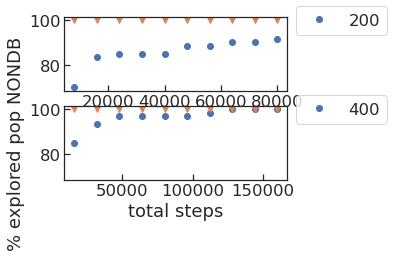

In [165]:
fig, ax = plt.subplots(2,figsize=(4,3),sharey=True )
for i in range(2):
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plotexp[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax[i].legend(bbox_to_anchor=(1., 1.25))
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdexp[list(aux.keys())[i]],'v')
ax[-1].set_xlabel('total steps'),ax[1].set_ylabel('% explored pop NONDB')

Plot difference in MSM populations

(Text(0.5, 0, 'total steps'), Text(0, 0.5, 'MSM pops - NONDB'))

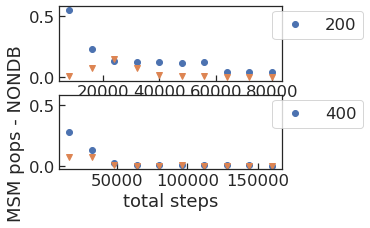

In [166]:
fig, ax = plt.subplots(2,figsize=(4,3),sharey=True )
for i in range(2):
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plotmpop[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax[i].legend(bbox_to_anchor=(1.4, 1.05))
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdmpop[list(aux.keys())[i]],'v')
ax[-1].set_xlabel('total steps'),ax[1].set_ylabel('MSM pops - NONDB')

Plot difference in relaxation times

(Text(0.5, 0, 'total steps'), Text(0, 0.5, '% relax times - NONDB'))

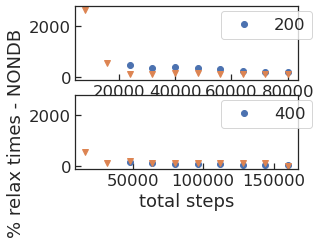

In [169]:
fig, ax = plt.subplots(2,figsize=(4,3),sharey=True )
for i in range(2):
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plottim[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax[i].legend(bbox_to_anchor=(1.1, 1.05))
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdtim[list(aux.keys())[i]],'v')
ax[-1].set_xlabel('total steps'),ax[1].set_ylabel('% relax times - NONDB')